# Visualization and statistical analysis

- Inclusive count: cells positive in any of the channel combination, then it is positive for this combination of channels.
- Exclusive count: cells positive in all of the channel combination, then it is positive for this combination of channels and is associated to this category.

Save the results as a 'destination folder/*-stats.csv' file

Define the result folder

In [1]:
import yaml
from pathlib import Path
from ipyfilechooser import FileChooser
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

srcdir, dstdir = "", ""
if Path("config.yml").exists():
    with open("config.yml", "r") as file:
        config = yaml.safe_load(file)
        if "source" in config.keys():
            srcdir = Path(config["source"])
        if "destination" in config.keys():
            dstdir = Path(config["destination"])

fc = FileChooser(dstdir, select_desc="Destination")
display(fc)

FileChooser(path='C:\Users\Amy Courtney\Documents\Temp\Analysis_Combined_1', filename='', title='', show_hidde…

In [2]:
import pandas as pd

dstdir = Path(fc.selected) if fc.selected is not None else Path(dstdir)
filelistname = dstdir / "filelist.csv"
filelist = pd.read_csv(filelistname)
filelist

,folder,name,channel1,channel2,channel3,channel4
0,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,10Aug2023_6a_Slices_F5_Stitched_Cropped_For_An...,dop2,fmrf,Th,nuclei
1,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,14Aug2023_3b_Slices_F1_Stitched_CroppedForAnal...,LGC009,vglut,Th,nuclei
2,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,1b_May28_2024_F3_Stitched_CroppedForAnalysis.ims,tbh,LGC009,vacht,nuclei
3,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_12Dec_1a17Dec_F1_Stitched_CroppedForAnaly...,tbh,DOP3a,Th,nuclei
4,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnal...,tbh,LGC007,vacht,nuclei
5,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_13Dec_3a17Dec_F1_Stitched_CroppedForAnaly...,vglut,ppp1,Th,nuclei
6,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnal...,vglut,LGC007,Th,nuclei
7,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_20Dec_1aBatch2_12Dec_F1_Stitched_CroppedF...,vgat,tph2,nuclei,xxx
8,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_20Dec_2aBatch2_12Dec_F1_Stitched_Cropped_...,LGC041,LGC046,Th,nuclei
9,C:\Users\Amy Courtney\Documents\Temp\Analysis_...,2023_20Dec_3aBatch2_12Dec_F1_Stitched_CroppedF...,LGC041,LGC046,vacht,nuclei


In [3]:
from itertools import chain, combinations
from functools import partial
from functools import reduce
import operator
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import napari
import dask


def get_files(dstdir, row, key=None):
    if key == "ims":
        return Path(row["folder"]) / row["name"]
    elif key == "regions":
        return Path(dstdir / str(row["name"]).replace(".ims", "-regions.json"))
    elif key == "labels":
        return Path(dstdir / str(row["name"]).replace(".ims", "-labels.tif"))
    elif key == "measurements":
        return Path(dstdir / str(row["name"]).replace(".ims", "-measurements.csv"))
    elif key == "stats":
        return Path(dstdir / str(row["name"]).replace(".ims", "-stats.csv"))
    else:
        return {
            "ims": get_files(dstdir, row, "ims"),
            "regions": get_files(dstdir, row, "regions"),
            "labels": get_files(dstdir, row, "labels"),
            "measurements": get_files(dstdir, row, "measurements"),
        }


def get_measurement_channels(df):
    """List the channels name from the measurement data"""
    return df.columns[6:]


def create_heatmaps(labels, df):
    channel_columns = [f"c{k}" for k in range(10) if f"c{k}" in df.columns]

    heatmaps = np.zeros([len(channel_columns), *labels.shape])
    for row in df.iloc:
        for k, c in enumerate(channel_columns):
            heatmaps[k][labels == row["label"]] = row[c]
    return heatmaps


def madstd(x):
    """Median std"""
    return 1.48 * np.median(np.abs(x - np.median(x)))


def powerset(iterable):
    """Compute the powerset of iterable"""
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))


def encode(row, channels, thresholds, encoder):
    """compute a code from the channels columns and the tresholds"""
    t = tuple([c for c in channels if row[c] > thresholds[c]])
    return encoder[t]


def encode_channels_exclusive(df, columns, thresholds):
    """Encode the channel in the data frame based on intensity

    Parameters
    ----------
    df : pd.DataFrame
    columns : List[str]
        list of columns names
    thresholds: List[float]
        list of threshold values

    Returns
    -------
    code_df and encoder, decoder dicts
    """
    pset = [x for x in powerset(columns)]
    encoder = {x: k for k, x in enumerate(pset)}
    decoder = {k: x for k, x in enumerate(pset)}
    decoder[0] = ("none",)
    decode_str = {
        a: b
        for a, b in enumerate(["+".join([str(e) for e in k]) for k in encoder.keys()])
    }
    cid = df.apply(
        partial(encode, channels=columns, encoder=encoder, thresholds=thresholds),
        axis=1,
    )
    code_df = pd.DataFrame({"label": df["label"], "id": cid})
    return code_df, decoder


def prod(iterable):
    return reduce(operator.mul, iterable, 1)


def encode_channels_inclusive(df, columns, thresholds):
    """Encode the channel in the data frame based on intensity

    Parameters
    ----------
    df : pd.DataFrame
    channels : List[str]
        list of channel names
    thresholds: List[float]
        list of threshold values

    Returns
    -------

    code_df and encoder, decoder dicts
    """
    pset = [x for x in powerset(columns)]
    decoder = {k + 1: "+".join([str(e) for e in x]) for k, x in enumerate(pset[1:])}
    code_df = pd.DataFrame(
        {
            "+".join([str(e) for e in k]): prod([df[e] > thresholds[e] for e in k])
            for k in pset[1:]
        }
    )
    code_df["label"] = df["label"]
    return code_df, decoder

def create_class_image(labels, codes, decoder, chunk_size=20):
    """Create a map of the binary codes as a label map

    Parameter
    ---------
    labels: np.array

    codes: pd.DataFrame
        data frame with a column label and a label code

    decoder: dict
        dictionary: {id: tuple(combination columns names)}

    Note add 1 to the code so that it is not set to background
    """
    def helper(stack, labels, codes, decoder):
        for row in codes.iloc:
            stack[labels == row["label"]] = row["id"] + 1
    
    stack = np.zeros(labels.shape, dtype=np.uint8)

    tsk = [
        dask.delayed(helper)(
            stack, labels, codes.iloc[n : n + chunk_size], decoder
        )
        for n in range(0, codes.shape[0], chunk_size)
    ]
    
    dask.compute(tsk)

    features = pd.DataFrame(
        {"code": ["background", *[" + ".join(decoder[k]) for k in decoder]]}
    )
    return stack, features

def create_class_masks(labels, codes, decoder, chunk_size=20):
    """Create a set of maps for each combination of labels

    Parameter
    ---------
    labels: np.array

    codes: pd.DataFrame
        data frame with a column label and a column per combination

    decoder: dict
        dictionary: {id: tuple(combination columns names)}

    """
    nc = len(decoder)
    stack = np.zeros([nc, *labels.shape], dtype=np.uint8)

    def helper(stack, labels, codes, decoder):
        for row in codes.iloc:
            for c in decoder:
                if row[decoder[c]] == 1:
                    stack[c - 1][labels == row["label"]] = 255

    tsk = [
        dask.delayed(helper)(
            stack, labels, codes.iloc[n : n + chunk_size], decoder
        )
        for n in range(0, codes.shape[0], chunk_size)
    ]

    dask.compute(tsk)
    names = [decoder[k] for k in decoder]
    return stack, names


def aggregate_combinations(input, decoder):
    """Aggregate the inputs based on combinations in the decoder

    Parameters
    ----------
    input: pd.DataFrame or np.array
        input on which to compute the aggregation
    decoder: dict
        mapping between keys of the input and the corresponding set of channels
    """
    output = input.copy()
    for k1 in decoder:
        for k2 in decoder:
            if len(decoder[k2]) > len(decoder[k1]):
                for y1 in decoder[k1]:
                    if y1 in decoder[k2]:
                        output[k1] = output[k1] + input[k2]
    return output

def map_intensity(labels, df, channels, chunk_size=20):
    """Set each label with the intensity store in the dataframe df

    The purpose of this is to help ind the adequate threshold

    Parameters
    ----------
    labels: ndarray (D,H,W)
        labels of the segmented nuclei in 3D
    df: pd.dataframe
        data frame with intensity measurement and matching labels indices
    channels: List
        list of the channels
    chunk_size: int
        size of the chunck

    Return
    ------
    map : ndarray (C,D,H,W)
        intensity map for each label
    """
    
    def helper(dst, labels, df, channels):
        for row in df.iloc:
            idx = labels == row["label"]
            for k, ch in enumerate(channels):
                dst[k][idx] = row[ch]

    dst = np.zeros((len(channels), *labels.shape))
    tsk = [
        dask.delayed(helper)(
            dst, labels, df.iloc[n : n + chunk_size], channels
        )
        for n in range(0, df.shape[0], chunk_size)
    ]
    dask.compute(tsk)

    return dst

In [4]:
import ipywidgets as widgets

w = widgets.Dropdown(
    options=[(x, k) for k, x in enumerate(filelist["name"])],
    value=1,
    description="Image:",
)
display(w)

Dropdown(description='Image:', index=1, options=(('10Aug2023_6a_Slices_F5_Stitched_Cropped_For_Analysis.ims', …

Load the image

In [5]:
from imaris_ims_file_reader.ims import ims

row = filelist.iloc[w.value]
resolution_level = 1  # need to be the same than the one used for processing
img = ims(get_files(dstdir, row, "ims"), ResolutionLevelLock=resolution_level)

Opening readonly file: C:\Users\Amy Courtney\Documents\Temp\Analysis_Combined_1\14Aug2023_3b_Slices_F1_Stitched_CroppedForAnalysis.ims 



Add codes to the dataframe

In [6]:
df = pd.read_csv(get_files(dstdir, row, "measurements"), index_col=0)
df = pd.DataFrame(df.to_records())
df

,label,roi,x,y,z,area,LGC009,vglut,Th
0,1,0.0,1022.833880,99.078792,4.525279,1523,0.000000,0.000000,0.000000
1,2,0.0,1121.100301,130.832497,3.696590,1994,0.000000,0.000000,0.000000
2,3,1.0,887.318987,136.248101,5.114768,1185,0.000000,0.000000,0.001406
3,4,1.0,653.907448,189.896602,5.066522,1383,0.000000,0.000000,0.000000
4,5,0.0,7.951132,330.169249,5.214541,839,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3837,3838,0.0,907.381750,2279.992551,41.424581,537,0.005923,0.000000,0.069665
3838,3839,0.0,379.494574,2361.427907,42.031008,645,1.824087,0.056201,11.301483
3839,3840,1.0,448.983685,2035.424184,42.000000,1042,0.806767,0.125157,1.939267
3840,3841,1.0,509.205882,2024.049412,42.580000,850,0.530574,0.331776,1.304656


In [7]:
labels = tifffile.imread(get_files(dstdir, row, "labels"))

df = pd.read_csv(get_files(dstdir, row, "measurements"), index_col=0)
df = pd.DataFrame(df.to_records())

channels = get_measurement_channels(df)

Map the intensity on the labels

In [8]:
cell_intensity = map_intensity(labels, df, channels)

Visualize the map of intensity to select threshold

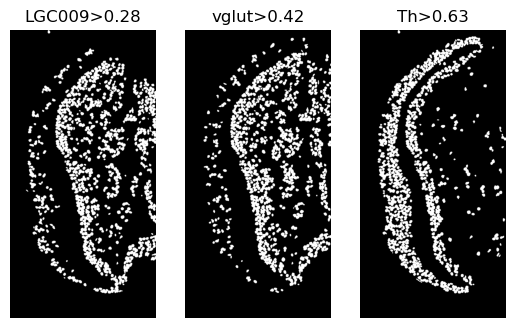

In [9]:
# default thresholds
thresholds = {c: df[c].median() + 0.5 * madstd(df[c]) for c in channels}
# custom threshold
#thresholds = {"LGC041": 2, "LGC046": 5, "Th": 0.9}
fig, ax = plt.subplots(1, len(channels))
for k, ch in enumerate(channels):
    ax[k].imshow(
        cell_intensity[k, cell_intensity.shape[1] // 2] > thresholds[ch], cmap="gray"
    )
    ax[k].set_axis_off()
    ax[k].set_title(f"{ch}>{thresholds[ch]:.2f}")

Encode the combination of channels

In [10]:
codes_in, decoder_in = encode_channels_inclusive(df, channels, thresholds)
codes_ex, decoder_ex = encode_channels_exclusive(df, channels, thresholds)

Show the cells as points for a quick visualization

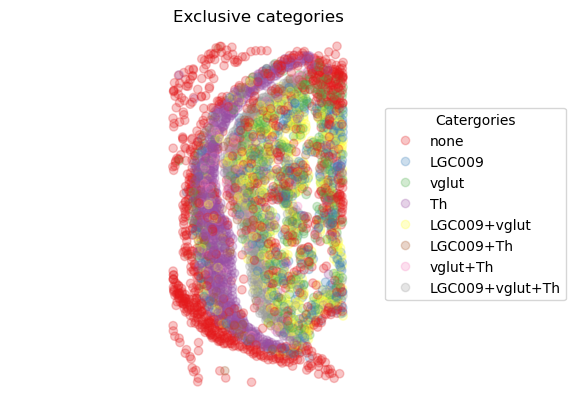

In [11]:
fig, ax = plt.subplots()
scatter = ax.scatter(df["x"], df["y"], c=codes_ex["id"], cmap="Set1", alpha=0.25)
ax.axis("equal")
ax.set_title("Exclusive categories")
ax.invert_yaxis()
plt.axis("off")
fig.legend(
    scatter.legend_elements()[0],
    ["+".join(decoder_ex[k]) for k in range(8)],
    loc="outside right",
    title="Catergories",
)

Compute the label code map for the exclusive labels (one single label map for encodes all the categories)

In [12]:
codemaps, features = create_class_image(labels, codes_ex, decoder_ex)


Text(0.5, 1.0, 'Exclusive labels')

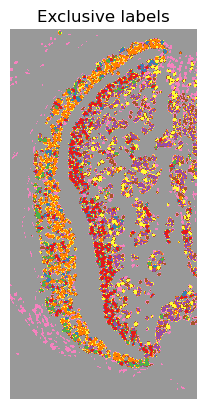

In [13]:
plt.imshow(codemaps.max()-codemaps[codemaps.shape[0]//2],cmap='Set1',interpolation=None)
plt.axis('off')
plt.title('Exclusive labels')

Compute the label maps of inclusive labels (one binary map per category)

In [14]:
maps, names = create_class_masks(labels, codes_in, decoder_in)

Visualization of each inclusive labels

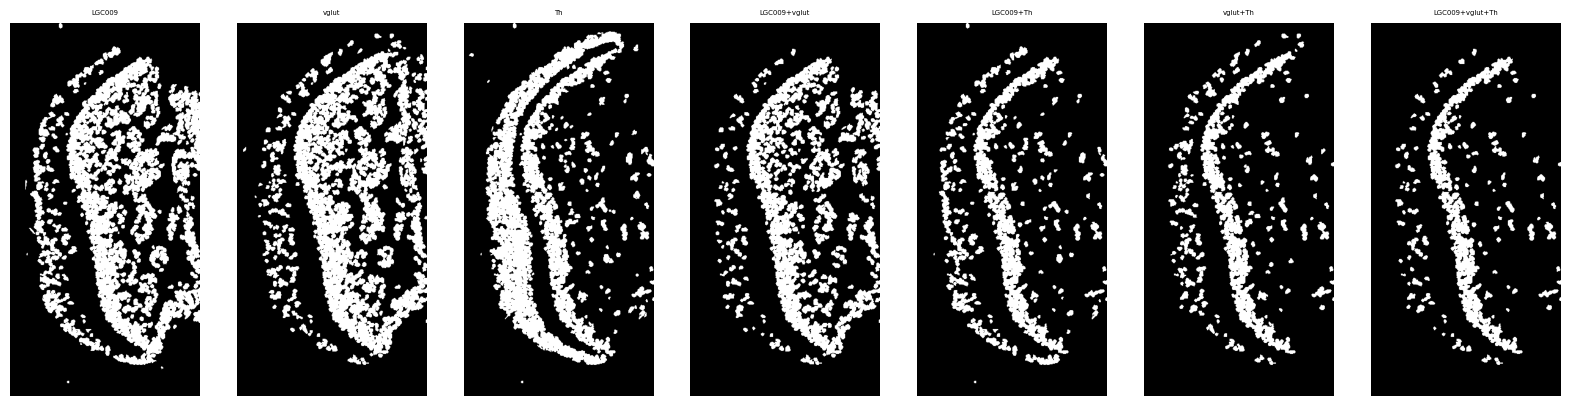

In [15]:
fig, ax = plt.subplots(1, len(names), figsize=(20, 5))
for k in range(len(names)):
    ax[k].imshow(np.amax(maps[k, :, ::4, ::4], 0), cmap="gray")
    ax[k].set(title=names[k])
    ax[k].title.set_fontsize(5)
    ax[k].set_axis_off()

Visualize the result in 3D using napari
- toggle the label layer to visualize the codes
- on the codemaps layer, tick the 'show selected' option and run through the labels to display the cells code by code

In [16]:
v = napari.view_image(
    img, channel_axis=1, name=[row[f"channel{k+1}"] for k in range(img.shape[1])]
)
v.add_labels(codemaps) # exclusive (categories)
v.add_image(maps,channel_axis=0,name=names) # inclusive

[<Image layer 'LGC009 [1]' at 0x20e09766d40>,
 <Image layer 'vglut [1]' at 0x20e195889a0>,
 <Image layer 'Th [1]' at 0x20e195e5cc0>,
 <Image layer 'LGC009+vglut' at 0x20e1960b7c0>,
 <Image layer 'LGC009+Th' at 0x20e19646380>,
 <Image layer 'vglut+Th' at 0x20e1966be80>,
 <Image layer 'LGC009+vglut+Th' at 0x20e1a9e2a40>]

# Statistical analysis and figure



In [17]:
# Define the image name variable
Image_Name = '1b_May28_2024_F3'

# Select the folder to save the files using manual input
save_folder = 'C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test'

if os.path.isdir(save_folder):
    # Retrieve and print the names of all layers
    layer_names = [layer.name for layer in v.layers]
    print("Layer names:", layer_names)

    # Save each layer and its MIP as TIFF files
    for layer_name in layer_names:
        layer = v.layers[layer_name]
        filename = os.path.join(save_folder, f"{Image_Name}_{layer_name}.tif")
        tifffile.imsave(filename, layer.data)
        print(f"Saved {layer_name} as {filename}")

        # Calculate and save the maximum intensity projection (MIP)
        mip = np.max(layer.data, axis=0)
        mip_rescaled = cv2.normalize(mip, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        mip_filename = os.path.join(save_folder, f"{Image_Name}_{layer_name}_MIP.tif")
        tifffile.imsave(mip_filename, mip_rescaled.astype(np.uint8))
        print(f"Saved rescaled MIP of {layer_name} as {mip_filename}")

        # If the layer is 'Codemaps', save each label separately and its MIP
        if layer_name == 'codemaps':
            unique_labels = np.unique(layer.data)
            for label in unique_labels:
                label_data = (layer.data == label).astype(np.uint8)
                label_filename = os.path.join(save_folder, f"{Image_Name}_{layer_name}_label_{label}.tif")
                tifffile.imsave(label_filename, label_data)
                print(f"Saved label {label} of {layer_name} as {label_filename}")

                # Calculate and save the MIP for each label
                label_mip = np.max(label_data, axis=0)
                # Rescale the MIP to 255 for white pixels
                label_mip_rescaled = cv2.normalize(label_mip, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
                label_mip_filename = os.path.join(save_folder, f"{Image_Name}_{layer_name}_label_{label}_MIP.tif")
                tifffile.imsave(label_mip_filename, label_mip_rescaled.astype(np.uint8))
                print(f"Saved rescaled MIP of label {label} of {layer_name} as {label_mip_filename}")

else:
    print("Invalid folder path. Exiting without saving files.")


Layer names: ['LGC009', 'vglut', 'Th', 'nuclei', 'codemaps', 'LGC009 [1]', 'vglut [1]', 'Th [1]', 'LGC009+vglut', 'LGC009+Th', 'vglut+Th', 'LGC009+vglut+Th']


C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\232933548.py:16: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(filename, layer.data)


Saved LGC009 as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_LGC009.tif
Saved rescaled MIP of LGC009 as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_LGC009_MIP.tif


C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\232933548.py:23: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(mip_filename, mip_rescaled.astype(np.uint8))


Saved vglut as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_vglut.tif
Saved rescaled MIP of vglut as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_vglut_MIP.tif
Saved Th as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_Th.tif
Saved rescaled MIP of Th as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_Th_MIP.tif
Saved nuclei as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_nuclei.tif
Saved rescaled MIP of nuclei as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_nuclei_MIP.tif
Saved codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps.tif
Saved rescaled MIP of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_MIP.tif


C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\232933548.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(label_filename, label_data)
C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\232933548.py:40: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(label_mip_filename, label_mip_rescaled.astype(np.uint8))


Saved label 0 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_0.tif
Saved rescaled MIP of label 0 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_0_MIP.tif
Saved label 1 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_1.tif
Saved rescaled MIP of label 1 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_1_MIP.tif
Saved label 2 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_2.tif
Saved rescaled MIP of label 2 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_2_MIP.tif
Saved label 3 of codemaps as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_codemaps_label_3.tif
Saved res

In [18]:
# Your original data processing code to create tbl_in
tbl_in = (
    codes_in.merge(df[["label", "roi"]], on="label")
    .drop(columns=["label"])
    .groupby("roi")  # group per roi
    .agg(["count", "sum"])  # count cell and positive cells
    .groupby(axis=1, level=0)  # group per category
    .apply(lambda df: 100 * df[df.columns[1]] / df[df.columns[0]])  # ratio
)

# Save tbl_in as CSV
csv_filename = f"{save_folder}/{Image_Name}_tbl_in.csv"
tbl_in.to_csv(csv_filename)

print(f"Saved tbl_in as {csv_filename}")


Saved tbl_in as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test/1b_May28_2024_F3_tbl_in.csv


C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\3669100686.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  codes_in.merge(df[["label", "roi"]], on="label")


In [19]:
tbl_ex = (
    codes_ex.merge(df[["label", "roi"]], on="label")
    .groupby(["roi", "id"])
    .agg("count")
    .reset_index()
)
tbl_ex["category"] = ["+".join(decoder_ex[x]) for x in tbl_ex["id"]]
tbl_ex = tbl_ex.pivot_table(values="label", columns="category", index="roi")
tbl_ex = tbl_ex.apply(lambda x: 100 * x / x.sum(), axis=1)
tbl_ex

# Save tbl_ex as CSV
csv_filename = f"{save_folder}/{Image_Name}_tbl_ex.csv"
tbl_ex.to_csv(csv_filename)

print(f"Saved tbl_ex as {csv_filename}")

Saved tbl_ex as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test/1b_May28_2024_F3_tbl_ex.csv


C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\3804793125.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tbl['ROI'] = filtered_tbl['ROI'].astype(str)  # Ensure ROI column is treated as string for mapping
C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\3804793125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tbl['ROI'] = filtered_tbl['ROI'].map(roi_recode)


Saved plot as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_Inclusive_Barplot.pdf


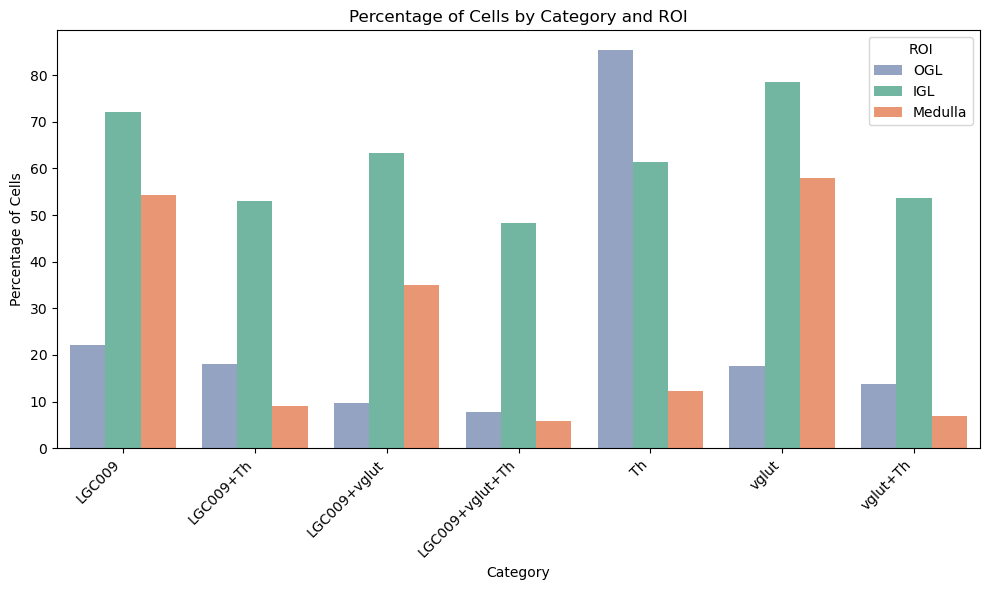

In [40]:
#tbl in bar plot all
tbl_in_transposed = tbl_in.T
tbl_long = tbl_in_transposed.reset_index().melt(id_vars=['index'], var_name='ROI', value_name='Percentage')
filtered_tbl = tbl_long[tbl_long['ROI'] != 0]

# Change ROI values
# Change ROI values using map function
roi_recode = {"1.0": "OGL", "2.0": "IGL", "3.0": "Medulla"}
filtered_tbl['ROI'] = filtered_tbl['ROI'].astype(str)  # Ensure ROI column is treated as string for mapping
filtered_tbl['ROI'] = filtered_tbl['ROI'].map(roi_recode)
# Rename 'index' column to 'category'
filtered_tbl = filtered_tbl.rename(columns={'index': 'Category'})

# Plotting the grouped bar plot (side-by-side)
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Percentage', hue='ROI', data=filtered_tbl,
            palette={'OGL': '#8da0cb', 'IGL': '#66c2a5', 'Medulla': '#fc8d62'})  # Specify colors

plt.title('Percentage of Cells by Category and ROI')
plt.xlabel('Category')
plt.ylabel('Percentage of Cells')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ROI')

# Ensure the save folder exists
os.makedirs(save_folder, exist_ok=True)

# Extract base name of the imported file
file_path = os.path.join(save_folder, f"{Image_Name}_tbl_in.csv")

# Show the plot and save as PDF and TIFF
plot_filename_pdf = os.path.join(save_folder, f"{Image_Name}_Inclusive_Barplot.pdf")
plot_filename_tiff = os.path.join(save_folder, f"{Image_Name}_Inclusive_Barplot.tiff")
plt.savefig(plot_filename_pdf, format='pdf', bbox_inches='tight')
# Uncomment the next line if you want to save as TIFF
# plt.savefig(plot_filename_tiff, format='tiff', bbox_inches='tight')

print(f"Saved plot as {plot_filename_pdf}")
# print(f"Saved plot as {plot_filename_tiff}")

plt.tight_layout()
plt.show()

In [ ]:
#tbl in bar plot all separately
# Plot each Category separately and save
for category in filtered_tbl['Category'].unique():
    plt.figure(figsize=(5, 7))
    sns.barplot(x='Category', y='Percentage', hue='ROI', data=filtered_tbl[filtered_tbl['Category'] == category],
                palette={'OGL': '#8da0cb', 'IGL': '#66c2a5', 'Medulla': '#fc8d62'})  # Specify colors

    plt.title(f'Percentage of Cells for Category "{category}" by ROI')
    plt.ylabel('Percentage of Cells')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='ROI')

    # Extract base name of the imported file
    plot_filename_pdf = os.path.join(save_folder, f"{Image_Name}_{category}_Inclusive_Barplot.pdf")
    plot_filename_tiff = os.path.join(save_folder, f"{Image_Name}_{category}_Inclusive_Barplot.tiff")
    plt.savefig(plot_filename_pdf, format='pdf', bbox_inches='tight')
    # Uncomment the next line if you want to save as TIFF
    # plt.savefig(plot_filename_tiff, format='tiff', bbox_inches='tight')

    print(f"Saved plot for category '{category}' as {plot_filename_pdf}")
    # print(f"Saved plot for category '{category}' as {plot_filename_tiff}")

    plt.tight_layout()
    plt.show()

C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\2519130268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tbl['ROI'] = filtered_tbl['ROI'].astype(str)  # Ensure ROI column is treated as string for mapping
C:\Users\Amy Courtney\AppData\Local\Temp\ipykernel_27632\2519130268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tbl['ROI'] = filtered_tbl['ROI'].map(roi_recode)


Saved plot as C:/Users/Amy Courtney/Documents/Temp/Output/1b_May28_2024_F3/test\1b_May28_2024_F3_Exclusive_Barplot.pdf


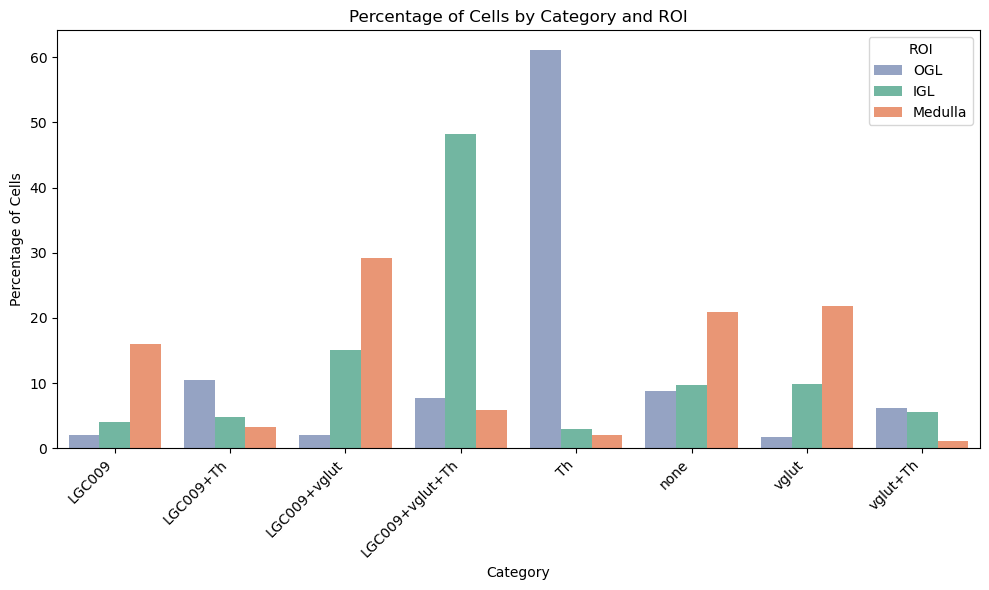

In [42]:
#tab ex bar plot all
tbl_ex_transposed = tbl_ex.T
tbl_long = tbl_ex_transposed.reset_index().melt(id_vars=['category'], var_name='ROI', value_name='Percentage')
filtered_tbl = tbl_long[tbl_long['ROI'] != 0]
roi_recode = {"1.0": "OGL", "2.0": "IGL", "3.0": "Medulla"}
filtered_tbl['ROI'] = filtered_tbl['ROI'].astype(str)  # Ensure ROI column is treated as string for mapping
filtered_tbl['ROI'] = filtered_tbl['ROI'].map(roi_recode)
filtered_tbl = filtered_tbl.rename(columns={'category': 'Category'})

# Plotting the grouped bar plot (side-by-side)
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Percentage', hue='ROI', data=filtered_tbl,
            palette={'OGL': '#8da0cb', 'IGL': '#66c2a5', 'Medulla': '#fc8d62'})  # Specify colors

plt.title('Percentage of Cells by Category and ROI')
plt.xlabel('Category')
plt.ylabel('Percentage of Cells')
plt.xticks(rotation=45, ha='right')
plt.legend(title='ROI')

# Ensure the save folder exists
os.makedirs(save_folder, exist_ok=True)

# Extract base name of the imported file
file_path = os.path.join(save_folder, f"{Image_Name}_tbl_in.csv")

# Show the plot and save as PDF and TIFF
plot_filename_pdf = os.path.join(save_folder, f"{Image_Name}_Exclusive_Barplot.pdf")
plot_filename_tiff = os.path.join(save_folder, f"{Image_Name}_Exclusive_Barplot.tiff")
plt.savefig(plot_filename_pdf, format='pdf', bbox_inches='tight')
# Uncomment the next line if you want to save as TIFF
# plt.savefig(plot_filename_tiff, format='tiff', bbox_inches='tight')

print(f"Saved plot as {plot_filename_pdf}")
# print(f"Saved plot as {plot_filename_tiff}")

plt.tight_layout()
plt.show()